## Contexto do problema

Instituições financeiras lidam diariamente com milhares de operações internas e transações que, quando mal monitoradas, podem gerar **risco operacional**.

Risco operacional envolve falhas em processos, sistemas, pessoas ou eventos externos, podendo resultar em:
- perdas financeiras
- falhas de compliance 
- impactos reputacionais

## Cenário simulado 

Neste projeto, será simulada uma base de dados contendo registros operacionais de uma instituição financeira fictícia 

Cada registro representa uma ocorrência operacional associada a:
- área responsável
- tipo de evento 
- data
- valor financeiro impactado 
- canal de origem 

O objetivo é identificar padrões que possam indicar **aumento de risco operacional**.

## Estrutura dos Dados

Cada linha do dataset representa uma ocorrência de risco operacional registrada pela instituição

A seguir estão descritas as principais variáveis consideradas na análise.

## Variáveis do Dataset 

- **id_ocorrencia**: identificador único da ocorrência
- **data_ocorrencia**: data em que o evento foi registrado 
- **area_responsavel**: área interna responsável pelo processo
- **tipo_evento**: classificação do evento operacional 
- **canal_origem**: canal onde o evento ocorreu (ex: digital, agência, backoffice)
- **valor_impacto**: valor financeiro estimado do impacto
- **nivel_risco**: classificação do risco (baixo, médio, alto, crítico)

In [77]:
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import psycopg2
from psycopg2 import sql, Error
from config import DB_CONFIG

import re

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import ollama
import json


In [78]:
# fixa seeds
random.seed(42)
np.random.seed(42)

print('✅ Seeds fixadas! Resultados serão sempre os mesmos.')

✅ Seeds fixadas! Resultados serão sempre os mesmos.


In [79]:
# Classifica risco baseado em múltiplas dimensões
def classificar_nivel_risco(evento):
    
    # DIMENSÃO 1: Impacto Financeiro (peso 45%)
    if evento['impacto_financeiro'] >= 1_000_000:
        pontos_financeiro = 4
    elif evento['impacto_financeiro'] >= 250_000:
        pontos_financeiro = 3
    elif evento['impacto_financeiro'] >= 50_000:
        pontos_financeiro = 2
    else:
        pontos_financeiro = 1
    
    # DIMENSÃO 2: Clientes Afetados (peso 30%)
    if evento['clientes_afetados'] >= 10_000:
        pontos_clientes = 4
    elif evento['clientes_afetados'] >= 1_000:
        pontos_clientes = 3     
    elif evento['clientes_afetados'] >= 100:
        pontos_clientes = 2
    else:
        pontos_clientes = 1
    
    # DIMENSÃO 3: Tempo Indisponibilidade (peso 15%)
    if evento['tempo_indisponibilidade'] >= 8:
        pontos_tempo = 4
    elif evento['tempo_indisponibilidade'] >= 4:
        pontos_tempo = 3
    elif evento['tempo_indisponibilidade'] >= 1:
        pontos_tempo = 2
    else:
        pontos_tempo = 1
    
    # DIMENSÃO 4: Criticidade Sistema (peso 10%)
    pontos_sistema = min(evento['criticidade_sistema'], 4)

    # SCORE PONDERADO
    score = (
        pontos_financeiro * 0.35 +
        pontos_clientes * 0.30 +
        pontos_tempo * 0.20 +
        pontos_sistema * 0.15
    )

    # CLASSIFICAÇÃO FINAL
    if score >= 2.6:
        return 'critico'
    elif score >= 2.2:
        return 'alto'
    elif score >= 1.75:
        return 'medio'
    else:
        return 'baixo'


def gerar_evento():
    
    # Gera características aleatórias
    impacto_financeiro = int(np.random.lognormal(mean=10, sigma=2.2))
    impacto_financeiro = min(impacto_financeiro, 10_000_000)
    impacto_financeiro = max(impacto_financeiro, 500)
    
    clientes_afetados = int(np.random.lognormal(mean=4, sigma=2.8))
    clientes_afetados = min(clientes_afetados, 100_000)
    clientes_afetados = max(clientes_afetados, 0)

    tempo_indisponibilidade = np.random.exponential(scale=2.5)
    tempo_indisponibilidade = min(tempo_indisponibilidade, 48)
    tempo_indisponibilidade = round(tempo_indisponibilidade, 2)

    criticidade_sistema = random.choices([1, 2, 3, 4, 5], weights=[40, 30, 15, 10, 5])[0]
    frequencia_evento = random.randint(1, 10)
    impacto_cliente = 1 if clientes_afetados > 0 else 0
    falha_processo = random.randint(0, 1)
    fraude_interna = random.choice([0, 0, 0, 1])
    recorrencia = random.randint(1, 5)

    # Datas
    dias_atras = random.randint(0, 30)
    hora_aleatoria = random.randint(0, 23)
    minuto_aleatorio = random.randint(0, 59)
    
    data_evento = datetime.now() - timedelta(
        days=dias_atras,
        hours=hora_aleatoria,
        minutes=minuto_aleatorio
    )

    # Monta evento SEM classificação ainda
    evento = {
        'data_evento': data_evento,
        'impacto_financeiro': impacto_financeiro,
        'impacto_cliente': impacto_cliente,
        'clientes_afetados': clientes_afetados,
        'tempo_indisponibilidade': tempo_indisponibilidade,
        'frequencia_evento': frequencia_evento,
        'criticidade_sistema': criticidade_sistema,
        'falha_processo': falha_processo,
        'fraude_interna': fraude_interna,
        'recorrencia': recorrencia
    }
    
    # AGORA classifica
    evento['nivel_risco'] = classificar_nivel_risco(evento)
    
    # Tempo de resolução baseado no nível
    nivel = evento['nivel_risco']
    
    if nivel == 'baixo':
        horas_resolucao = random.randint(1, 24)
    elif nivel == 'medio':
        horas_resolucao = random.randint(4, 48)
    elif nivel == 'alto':
        horas_resolucao = random.randint(12, 72)
    else:  # crítico
        horas_resolucao = random.randint(24, 168)
    
    data_resolucao = data_evento + timedelta(hours=horas_resolucao)
    evento['data_resolucao'] = data_resolucao
    evento['tempo_resolucao_horas'] = horas_resolucao
    
    return evento

print("✅ Funções atualizadas!")

✅ Funções atualizadas!


In [80]:
eventos = [gerar_evento() for _ in range(5_000)]
df = pd.DataFrame(eventos)

print('\n📊 Eventos gerados com sucesso!')
print('=' * 60)
print(f'Total: {len(df)} eventos')
print("\n📈 DISTRIBUIÇÃO POR NÍVEL DE RISCO:")
print(df['nivel_risco'].value_counts().sort_index())
print("\n📊 PERCENTUAL:")
print(df['nivel_risco'].value_counts(normalize=True).sort_index().round(4) * 100)
print('=' * 60)


📊 Eventos gerados com sucesso!
Total: 5000 eventos

📈 DISTRIBUIÇÃO POR NÍVEL DE RISCO:
nivel_risco
alto        494
baixo      2875
critico     184
medio      1447
Name: count, dtype: int64

📊 PERCENTUAL:
nivel_risco
alto        9.88
baixo      57.50
critico     3.68
medio      28.94
Name: proportion, dtype: float64


In [81]:
contagem = df["nivel_risco"].value_counts()
percentual = df["nivel_risco"].value_counts(normalize=True) * 100

resultado = pd.DataFrame({
    "quantidade": contagem,
    "percentual (%)": percentual.round(2)
})

print("\n📊 DISTRIBUIÇÃO DOS EVENTOS")

resultado


📊 DISTRIBUIÇÃO DOS EVENTOS


,quantidade,percentual (%)
nivel_risco,,
baixo,2875,57.50
medio,1447,28.94
alto,494,9.88
critico,184,3.68


In [82]:
# Preparação dos dados para ML
X = df.drop(columns=[
    "nivel_risco",
    "data_evento",
    "data_resolucao",
    "tempo_resolucao_horas",
    "impacto_cliente"
])
y = df["nivel_risco"]

print("\n📊 Features do modelo: \n")
print(X.dtypes)
print(f"\n✅ Shape: {X.shape}")
print(f"✅ Target: {y.name} com {y.nunique()} classes")


📊 Features do modelo: 

impacto_financeiro           int64
clientes_afetados            int64
tempo_indisponibilidade    float64
frequencia_evento            int64
criticidade_sistema          int64
falha_processo               int64
fraude_interna               int64
recorrencia                  int64
dtype: object

✅ Shape: (5000, 8)
✅ Target: nivel_risco com 4 classes


In [83]:
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("\n📊 Divisão dos dados: \n")
print(f"Treino: {x_train.shape[0]} eventos")
print(f"Teste: {x_test.shape[0]} eventos")
print(f"Features: {x_train.shape[1]}")


📊 Divisão dos dados: 

Treino: 3500 eventos
Teste: 1500 eventos
Features: 8


In [84]:
# Treinamento do modelo
smote = SMOTE(random_state=42, k_neighbors=3)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

print(f'📊 Eventos balanceados: {len(y_train_balanced)} (era {len(y_train)})')

print('🤖 Treinando Random Forest...')

modelo = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

modelo.fit(x_train_balanced, y_train_balanced)

print("✅ Modelo treinado com sucesso!")

# Mostra os parâmetros do modelo
modelo

📊 Eventos balanceados: 8048 (era 3500)
🤖 Treinando Random Forest...
✅ Modelo treinado com sucesso!


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [85]:
# avalição final do modelo

THRESHOULD_CRITICO = 0.30

y_pred_proba = modelo.predict_proba(x_test)
classes = modelo.classes_
idx_critico = list(classes).index('critico')

# aplica threshold customizado
y_pred_final = []

for i in range(len(x_test)):
    probas = y_pred_proba[i]
    if probas[idx_critico] >= THRESHOULD_CRITICO:
        y_pred_final.append('critico')
    else:
        y_pred_final.append(classes[probas.argmax()])

# Relatório completo
print('\n📊 Relatório de classificação final:')
print("=" * 70)
print(classification_report(y_test, y_pred_final))

# Foco em crítico
print("\n🎯 Foco na classe crítica (Threshold 30%):")
print("-" * 70)
report_dict = classification_report(y_test, y_pred_final, output_dict=True)

if 'critico' in report_dict:
    critico = report_dict['critico']
    total = int(critico['support'])
    detectados = int(critico['recall'] * total)
    perdidos = total - detectados

    print(f'Recall: {critico['recall']*100:.1f}%')
    print(f'Precision: {critico['precision']*100:.1f}%')
    print(f'F1-Score: {critico['f1-score']*100:.1f}%')
    print(f'\n📈 De {total} eventos críticos:')
    print(f'✅ Detectados: {detectados}')
    print(f'❌ Perdidos:   {perdidos}')

print('=' * 70)
print('\n💡 Otimizações aplicadas:')
print('1. SMOTE para balanceamento de classes')
print('2. Threshold de 30% para maximizar recall de críticos')



📊 Relatório de classificação final:
              precision    recall  f1-score   support

        alto       0.77      0.76      0.76       148
       baixo       0.98      0.97      0.97       863
     critico       0.75      0.84      0.79        55
       medio       0.89      0.91      0.90       434

    accuracy                           0.92      1500
   macro avg       0.85      0.87      0.86      1500
weighted avg       0.92      0.92      0.92      1500


🎯 Foco na classe crítica (Threshold 30%):
----------------------------------------------------------------------
Recall: 83.6%
Precision: 75.4%
F1-Score: 79.3%

📈 De 55 eventos críticos:
✅ Detectados: 46
❌ Perdidos:   9

💡 Otimizações aplicadas:
1. SMOTE para balanceamento de classes
2. Threshold de 30% para maximizar recall de críticos



📊 Importância das features
                feature  importance
     impacto_financeiro    0.364416
      clientes_afetados    0.273730
tempo_indisponibilidade    0.150846
    criticidade_sistema    0.092050
      frequencia_evento    0.049491
            recorrencia    0.041148
         falha_processo    0.016475
         fraude_interna    0.011844


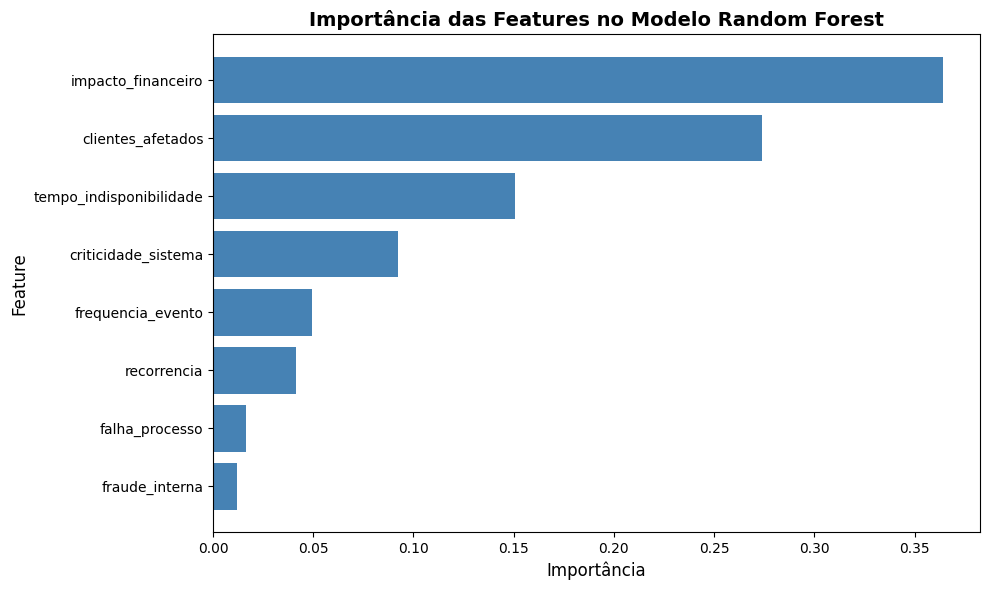


💡 Interpretação:
Features com maior importância têm mais peso nas decisões do modelo.
Impacto financeiro e clientes afetados devem ser as mais relevantes,
validando que o modelo aprendeu os padrões esperados.


In [86]:
# feature importance
importancias = pd.DataFrame({
    'feature': x_train.columns,
    'importance': modelo.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Importância das features")
print("=" * 70)
print(importancias.to_string(index=False))
print("=" * 70)

# gráfico 
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importance'], color='steelblue')
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Importância das Features no Modelo Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n💡 Interpretação:")
print("Features com maior importância têm mais peso nas decisões do modelo.")
print("Impacto financeiro e clientes afetados devem ser as mais relevantes,")
print("validando que o modelo aprendeu os padrões esperados.")

# Custo Assimétrico do Erro

Em risco operacional bancário, **nem todos os erros têm o mesmo peso**.

## ⚠️ Impacto dos Erros

### Erro Grave: Classificar CRÍTICO como BAIXO
- Evento de alto impacto não recebe resposta adequada
- Prejuízo financeiro pode escalar de R$ 10k → R$ 5M
- Risco reputacional e regulatório
- Multas do Banco Central
- Perda de clientes

**Custo estimado: R$ 500k - R$ 5M**

### Erro Aceitável: Classificar BAIXO como MÉDIO  
- Resposta mais cautelosa que o necessário
- Recursos extras alocados desnecessariamente
- Sem impacto ao cliente ou reputação

**Custo estimado: R$ 500 - R$ 2k**

## Estratégia Adotada

Por isso, o modelo foi otimizado para **maximizar recall da classe crítica**:

1. **SMOTE**: Balanceamento de classes minoritárias
2. **Threshold 30%**: Sensibilidade maior para detectar críticos
3. **Class weight balanced**: Penalização maior por erro em críticos

**Resultado**: Recall de 83.6% em críticos, aceitando precision de 75.4%

É preferível ter **alarmes falsos** (classificar médio como crítico) do que **perder eventos críticos reais**.

---

**Validação:** Feature Importance confirmou que o modelo aprendeu corretamente os padrões, com impacto financeiro (36.4%) e clientes afetados (27.4%) como features mais relevantes, alinhado aos pesos definidos na classificação multidimensional.

In [87]:
df.shape

(5000, 13)

In [88]:
# criar tabela no postgreSQL
def criar_tabela_eventos():
    
    try:
        # conecta
        conexao = psycopg2.connect(**DB_CONFIG)
        print('✅ PostgreSQL conectado com sucesso!')
        print(f'✅ Versão: {conexao.server_version}')

        cursor = conexao.cursor()

        # PRIMEIRO: Remove tabela antiga
        print('🗑️  Removendo tabela antiga...')
        cursor.execute("DROP TABLE IF EXISTS eventos_risco CASCADE;")
        conexao.commit()
        print('✅ Tabela antiga removida!')

        # SEGUNDO: Cria tabela nova
        print('📝 Criando nova tabela...')
        query = """
        CREATE TABLE eventos_risco (
            id SERIAL PRIMARY KEY,
            evento_id VARCHAR(100) UNIQUE NOT NULL,
            data_evento TIMESTAMP NOT NULL,
            data_resolucao TIMESTAMP,
            tempo_resolucao_horas FLOAT,
            impacto_financeiro DECIMAL(15, 2) NOT NULL,
            impacto_cliente INTEGER,
            clientes_afetados INTEGER,
            tempo_indisponibilidade FLOAT,
            frequencia_evento INTEGER,
            criticidade_sistema INTEGER,
            falha_processo INTEGER,
            fraude_interna INTEGER,
            recorrencia INTEGER,
            nivel_risco VARCHAR(20) NOT NULL,
            status VARCHAR(20) DEFAULT 'pendente',
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
        """
        
        cursor.execute(query)
        conexao.commit()
        print('✅ Tabela eventos_risco criada!')

        # TERCEIRO: Cria índices
        print('📊 Criando índices...')
        indices = """
        CREATE INDEX idx_nivel_risco ON eventos_risco(nivel_risco);
        CREATE INDEX idx_data_evento ON eventos_risco(data_evento);
        CREATE INDEX idx_impacto ON eventos_risco(impacto_financeiro);
        CREATE INDEX idx_clientes ON eventos_risco(clientes_afetados);
        CREATE INDEX idx_status ON eventos_risco(status);
        """
        
        cursor.execute(indices)
        conexao.commit()
        print('✅ Índices criados!')

        cursor.close()
        conexao.close()

        print('\n🎉 TUDO PRONTO!')
        return True

    except Exception as e:
        print(f'❌ Erro ao criar tabela: {e}')
        return False


# cria a tabela
criar_tabela_eventos()

✅ PostgreSQL conectado com sucesso!
✅ Versão: 180001
🗑️  Removendo tabela antiga...
✅ Tabela antiga removida!
📝 Criando nova tabela...
✅ Tabela eventos_risco criada!
📊 Criando índices...
✅ Índices criados!

🎉 TUDO PRONTO!


True

In [89]:
# salva eventos no postgree

def salvar_evento(evento, cursor):
    """
    Salva um evento usando cursor existente
    """
    try:
        # gera id único
        evento_id = (
            f"EVT-{evento['data_evento'].strftime('%Y%m%d%H%M%S')}-"
            f"{random.randint(1000, 9999)}"
        )
        
        # sql para inserir
        query = """
        INSERT INTO eventos_risco (
            evento_id, data_evento, data_resolucao, tempo_resolucao_horas,
            impacto_financeiro, impacto_cliente, clientes_afetados,
            tempo_indisponibilidade, frequencia_evento, criticidade_sistema,
            falha_processo, fraude_interna, recorrencia, nivel_risco
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        ON CONFLICT (evento_id) DO NOTHING;
        """
        
        cursor.execute(
            query,
            (
                evento_id,
                evento['data_evento'],
                evento['data_resolucao'],
                evento['tempo_resolucao_horas'],
                evento['impacto_financeiro'],
                evento['impacto_cliente'],
                evento['clientes_afetados'],
                evento['tempo_indisponibilidade'],
                evento['frequencia_evento'],
                evento['criticidade_sistema'],
                evento['falha_processo'],
                evento['fraude_interna'],
                evento['recorrencia'],
                evento['nivel_risco']
            ),
        )
        
        return True
        
    except Exception as e:
        print(f"❌ Erro ao salvar: {e}")
        return False


print('💾 Salvando eventos no PostgreSQL...')

try:
    conexao = psycopg2.connect(**DB_CONFIG)
    cursor = conexao.cursor()
    
    eventos_salvos = 0
    
    for i, evento in enumerate(eventos):
        if salvar_evento(evento, cursor): 
            eventos_salvos += 1
        
        # mostra progresso a cada 1.000
        if (i + 1) % 1000 == 0:
            print(f'salvos: {i + 1}/5000')
    
    conexao.commit()
    
    cursor.close()
    conexao.close()
    
    print(f'\n✅ Total de eventos salvos: {eventos_salvos}/5000')
    
except Exception as e:
    print(f'❌ Erro: {e}')

💾 Salvando eventos no PostgreSQL...
salvos: 1000/5000
salvos: 2000/5000
salvos: 3000/5000
salvos: 4000/5000
salvos: 5000/5000

✅ Total de eventos salvos: 5000/5000


In [90]:
PROMPT_BASE = """
Você é a Yoyo, uma assistente de gestão de risco operacional.
Você representa uma analista experiente, atenciosa e confiável.

TOM DE VOZ:
- Seja educada, simpática e acolhedora.
- Seja clara e objetiva, mas com linguagem humana.
- Demonstre cuidado com a situação e com as pessoas impactadas.
- Evite jargões desnecessários.
- Pode usar emojis com moderação (ex: ⚠️ 🚨 📌).

REGRAS OBRIGATÓRIAS:
- Use SOMENTE as informações fornecidas no CONTEXTO.
- NÃO invente dados, números ou causas.
- NÃO faça suposições.
- NÃO altere o nível de risco informado.
- NÃO use termos relativos como "hoje", "ontem", "amanhã".
- SEMPRE use a data COMPLETA fornecida COM O HORÁRIO! (exemplo: "21/12/2025").
- Se algo não estiver no contexto, diga:
  "Não tenho dados suficientes para afirmar isso."

SEU PAPEL:
- Explicar o evento de forma compreensível para a gestão.
- Justificar por que ele merece atenção.
- Sugerir ações iniciais de mitigação com cuidado e responsabilidade.
- Apoiar a tomada de decisão, sem substituir a decisão humana.

FORMATO DE RESPOSTA:
- Parágrafos curtos.
- Listas quando fizer sentido.
- Linguagem próxima e respeitosa.
"""
print("✅ Prompt Yoyo carregado!")


✅ Prompt Yoyo carregado!


In [91]:
def yoyo_gerar_briefing_phi3(evento):
    contexto = f"""
CONTEXTO DO EVENTO:
- ID: {evento['evento_id']}
- Nível de Risco: {evento['nivel_risco'].upper()}
- Impacto Financeiro: R$ {evento['impacto_financeiro']:,.2f}
- Clientes Afetados: {evento['clientes_afetados']:,}
- Tempo de Indisponibilidade: {evento['tempo_indisponibilidade']:.1f} horas
- Criticidade do Sistema: {evento['criticidade_sistema']}/5
- Data: {evento['data_evento'].strftime('%d/%m/%Y às %H:%M')}
"""
    
    instrucao = """
Com base APENAS no contexto acima:
1. Explique o evento em 2-3 frases (resumo executivo)
2. Justifique a classificação de risco
3. Sugira 3-5 ações imediatas

Seja objetiva e use linguagem clara e simpática.
"""

    prompt_completo = PROMPT_BASE + "\n\n" + contexto + "\n\n" + instrucao

    try:
        response = ollama.generate(
            model='phi3',
            prompt=prompt_completo,
            options={
                'temperature':0.3,
                'num_predict': 300
            }
        
        )
        return response['response']
    except Exception as e:
        return f'❌ Erro ao gerar briefing: {e}'
    
print("✅ Função briefing Phi-3 criada!")

✅ Função briefing Phi-3 criada!


In [92]:
def buscar_proximo_urgente():
    try:
        conexao = psycopg2.connect(**DB_CONFIG)
        cursor = conexao.cursor()
        
        query = """
        SELECT 
            evento_id,
            data_evento,
            nivel_risco,
            impacto_financeiro,
            clientes_afetados,
            tempo_indisponibilidade,
            criticidade_sistema
        FROM eventos_risco
        WHERE status = 'pendente'
        ORDER BY 
            CASE nivel_risco
                WHEN 'critico' THEN 1
                WHEN 'alto' THEN 2
                WHEN 'medio' THEN 3
                WHEN 'baixo' THEN 4
            END,
            impacto_financeiro DESC
        LIMIT 1;
        """
        
        cursor.execute(query)
        resultado = cursor.fetchone()
        
        cursor.close()
        conexao.close()
        
        if resultado:
            return {
                'evento_id': resultado[0],
                'data_evento': resultado[1],
                'nivel_risco': resultado[2],
                'impacto_financeiro': resultado[3],
                'clientes_afetados': resultado[4],
                'tempo_indisponibilidade': resultado[5],
                'criticidade_sistema': resultado[6]
            }
        else:
            return None
            
    except Exception as e:
        print(f"❌ Erro ao buscar evento: {e}")
        return None

print("✅ Função buscar evento criada!")

✅ Função buscar evento criada!


In [93]:
def criar_tabela_memoria():
    try:
        conexao = psycopg2.connect(**DB_CONFIG)
        cursor = conexao.cursor()

        print('🗑️  Removendo tabela antiga se existir...')
        cursor.execute('DROP TABLE IF EXISTS conversas_yoyo CASCADE;')
        conexao.commit()

        print('📝 Criando tabela conversas_yoyo...')
        query = """
        CREATE TABLE conversas_yoyo (
            id SERIAL PRIMARY KEY,
            usuario_id VARCHAR(100) DEFAULT 'gestor_padrao',
            nome_usuario VARCHAR(100),
            evento_atual VARCHAR(100),
            ultimo_comando TEXT,
            eventos_vistos TEXT[],
            historico JSONB,
            primeira_interacao BOOLEAN DEFAULT TRUE,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
        """
        cursor.execute(query)
        conexao.commit()

        print('📊 Criando índices...')
        cursor.execute("CREATE INDEX idx_usuario ON conversas_yoyo(usuario_id);")
        conexao.commit()

        cursor.close()
        conexao.close()

        print('✅ Tabela de memória criada!')
        return True
    
    except Exception as e:
        print(f'❌ Erro: {e}')
        return False
    
criar_tabela_memoria()

🗑️  Removendo tabela antiga se existir...
📝 Criando tabela conversas_yoyo...
📊 Criando índices...
✅ Tabela de memória criada!


True

In [94]:
def  carregar_memoria(usuario_id='gestor_padrao'):
    try: 
        conexao = psycopg2.connect(**DB_CONFIG)
        cursor = conexao.cursor()

        cursor.execute(
            "SELECT nome_usuario, evento_atual, ultimo_comando, eventos_vistos, historico, primeira_interacao FROM conversas_yoyo WHERE usuario_id = %s",
            (usuario_id,)
        )

        resultado = cursor.fetchone()
        cursor.close()
        conexao.close()

        if resultado:
            return {
                'nome_usuario': resultado[0],
                'evento_atual': resultado[1],
                'ultimo_comando': resultado[2],
                'eventos_vistos': resultado[3] or [],
                'historico': resultado[4] or [],
                'primeira_interacao': resultado[5]
            }
        else:
            return {
                'nome_usuario': None,
                'evento_atual': None,
                'ultimo_comando': None,
                'eventos_vistos': [],
                'historico': [],
                'primeira_interacao': True
            }
        
    except Exception as e:
        print(f'❌ Erro ao carregar memória: {e}')
        return None

def salvar_memoria(usuario_id, nome_usuario, evento_atual, ultimo_comando, eventos_vistos, historico):
    try:
        conexao = psycopg2.connect(**DB_CONFIG)
        cursor = conexao.cursor()

        cursor.execute(
            "SELECT id FROM conversas_yoyo WHERE usuario_id = %s",
            (usuario_id,)
        )

        existe = cursor.fetchone()

        if existe:
            cursor.execute("""
                UPDATE conversas_yoyo 
                SET nome_usuario = %s,
                    evento_atual = %s,
                    ultimo_comando = %s,
                    eventos_vistos = %s,
                    historico = %s,
                    primeira_interacao = FALSE,
                    updated_at = NOW()
                WHERE usuario_id = %s
            """, (nome_usuario, evento_atual, ultimo_comando, eventos_vistos, json.dumps(historico), usuario_id))
            
        else:
            cursor.execute("""
                INSERT INTO conversas_yoyo 
                (usuario_id, nome_usuario, evento_atual, ultimo_comando, eventos_vistos, historico, primeira_interacao)
                VALUES (%s, %s, %s, %s, %s, %s, FALSE)
            """, (usuario_id, nome_usuario, evento_atual, ultimo_comando, eventos_vistos, json.dumps(historico)))
        
        conexao.commit()
        cursor.close()
        conexao.close()
        
        return True
    
    except Exception as e:
        print(f'❌ Erro ao salvar memória: {e}')
        return False

print('✅ Funções de memória criadas!')

✅ Funções de memória criadas!


In [95]:
class YoyoIA:
    def __init__(self, usuario_id='gestor_padrao'):
        self.usuario_id = usuario_id
        self.memoria = carregar_memoria(usuario_id)
    
    def processar(self, mensagem):
        contexto = self._montar_contexto(mensagem)

        response = ollama.generate(
            model='phi3',
            prompt=contexto,
            options={
                'temperature': 0.4,
                'num_predict': 400
            }
        )

        resposta = response['response']
        self._atualizar_memoria(mensagem, resposta)

        return resposta
    
    def _montar_contexto(self, mensagem):
        eventos_status = self._contar_eventos()

        if self.memoria['primeira_interacao'] and not self.memoria['nome_usuario']:
            contexto_situacao = """
SITUAÇÃO: Primeira interação com novo usuário. 

TAREFA: Apresente-se como Yoyo e pergunte o nome da pessoa de forma amigável.
"""
        
        elif self.memoria['primeira_interacao'] and self.memoria['nome_usuario'] is None:
            self._salvar_nome(mensagem)
            nome = self.memoria['nome_usuario']

            contexto_situacao = f"""
SITUAÇÃO: Você acabou de conhecer {nome}.

STATUS DOS EVENTOS:
{eventos_status}

TAREFA: 
1. Dê boas-vindas calorosas (use linguagem neutra, sem "bem-vindo" ou "bem-vinda")
2. Mostre o status atual dos eventos
3. Explique brevemente o que você pode fazer
4. Pergunte o que a pessoa gostaria de ver primeiro
"""
        
        else: 
            nome = self.memoria['nome_usuario'] or "Gestor"

            if 'urgente' in mensagem.lower() or 'próximo' in mensagem.lower() or 'proximo' in mensagem.lower():
                evento = buscar_proximo_urgente()
                
                if evento:
                    self.memoria['evento_atual'] = evento['evento_id']
                    
                    contexto_evento = f"""
EVENTO ENCONTRADO:
- ID: {evento['evento_id']}
- Nível: {evento['nivel_risco'].upper()}
- Impacto: R$ {evento['impacto_financeiro']:,.2f}
- Clientes: {evento['clientes_afetados']:,}
- Tempo: {evento['tempo_indisponibilidade']:.1f}h
- Criticidade: {evento['criticidade_sistema']}/5
- Data: {evento['data_evento'].strftime('%d/%m/%Y às %H:%M')}
"""
                    
                    contexto_situacao = f"""
SITUAÇÃO: {nome} pediu o próximo evento urgente.

{contexto_evento}

TAREFA:
1. Gere briefing executivo completo do evento
2. Explique resumo, justificativa e ações
3. Ao final, sugira próximas opções
"""
                else:
                    contexto_situacao = f"""
SITUAÇÃO: {nome} pediu próximo urgente, mas não há eventos pendentes.

TAREFA: Informe que não há eventos pendentes de forma positiva.
"""
            
            else:
                contexto_situacao = f"""
SITUAÇÃO: Conversando com {nome}.

STATUS: {eventos_status}

MEMÓRIA:
- Evento atual: {self.memoria['evento_atual'] or 'Nenhum'}
- Último comando: {self.memoria['ultimo_comando'] or 'Nenhum'}

MENSAGEM: "{mensagem}"

TAREFA: Responda apropriadamente à mensagem.
"""
        
        return PROMPT_BASE + "\n\n" + contexto_situacao
    
    def _contar_eventos(self):
        try: 
            conexao = psycopg2.connect(**DB_CONFIG)
            cursor = conexao.cursor()

            cursor.execute("""
                SELECT nivel_risco, COUNT(*) 
                FROM eventos_risco 
                WHERE status = 'pendente'
                GROUP BY nivel_risco
            """)
            
            contagem = cursor.fetchall()
            cursor.close()
            conexao.close()
            
            resultado = []
            for nivel, count in contagem:
                resultado.append(f"- {nivel.capitalize()}: {count}")
            
            return '\n'.join(resultado) if resultado else "- Nenhum evento pendente"
            
        except Exception as e:
            return "Erro ao verificar eventos"
    
    def _salvar_nome(self, nome):
        self.memoria['nome_usuario'] = nome.strip()
        self.memoria['primeira_interacao'] = False

    def _atualizar_memoria(self, mensagem, resposta):
        salvar_memoria(
            self.usuario_id,
            self.memoria['nome_usuario'],
            self.memoria['evento_atual'],
            mensagem,
            self.memoria['eventos_vistos'],
            []
        )

print('✅ Yoyo 100% IA Generativa criada!')

✅ Yoyo 100% IA Generativa criada!
